In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
class Value:
    def __init__(self, data, _children=(), _op='', label='' ):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
    def __repr__(self):
        return f"Value(data={self.data})"

    # Value + 1 or Value + Value
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+' )
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out
    # 1 + Value
    def __radd__(self, other):
        return self + other

    # Value * Value or Value * k
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad +=  other.data * out.grad
            other.grad +=  self.data * out.grad
        out._backward = _backward
        return out
    # k * Value
    def __rmul__(self, other):
        return self * other

    
    def exp(self):
        print("exp getting called")
        
        out = Value(math.exp(self.data), (self,), "exp")

        def _backward():
            print(out.data, out.grad)
            # self.grad += out.data * out.grad
            self.grad = 0.24319
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int or float"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            power = other  - 1
            dataToPower = self.data ** power
            total =  other * dataToPower
            self.grad += total * out.grad
        out._backward = _backward
        
        return out

    def __truediv__(self, other):
        
        return self * other**-1

    def __neg__(self):
        return self *-1

    def __sub__(self, other):
        return self + (-other)
        

    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1) /(math.exp(2*n) + 1 ) 
        out = Value(t, (self, ), 'tanh output')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build_topo(child)
            topo.append(node)
        build_topo(self)
        self.grad = 1
        for node in reversed(topo):
            node._backward()



In [5]:
from graphviz import Digraph

In [6]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root):
    dot =  Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name= uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

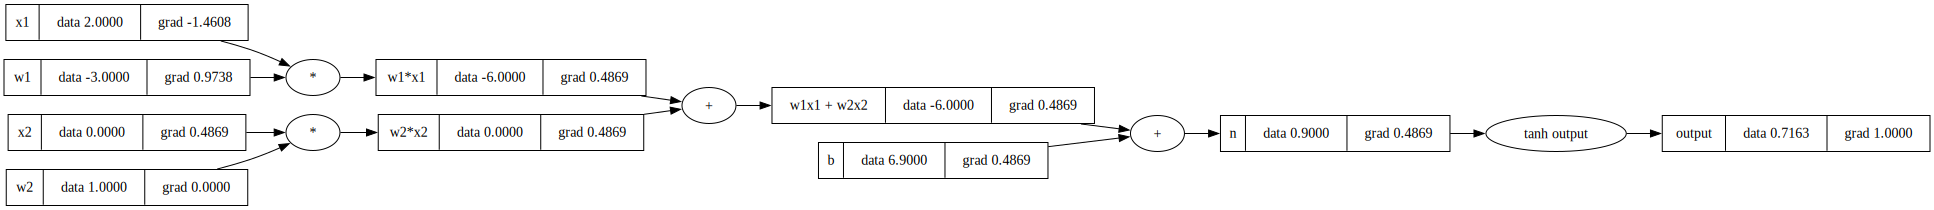

In [7]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.9, label='b')

w1x1 = w1*x1; w2x2 = w2*x2;
w1x1.label = 'w1*x1'
w2x2.label = 'w2*x2'
sum =  w1x1 + w2x2; sum.label= 'w1x1 + w2x2'
n =  sum + b; n.label = 'n'
o = n.tanh()

o.label = "output"
o.backward()
draw_dot(o)


exp getting called
Value(data=6.04964746441295)
6.04964746441295 0.1418510649004877
6.04964746441295 0.040243449226804756


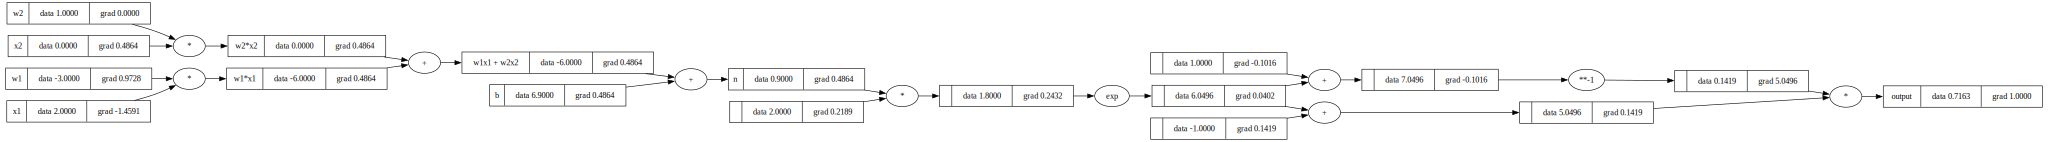

In [8]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.9, label='b')

w1x1 = w1*x1; w2x2 = w2*x2;
w1x1.label = 'w1*x1'
w2x2.label = 'w2*x2'
sum =  w1x1 + w2x2; sum.label= 'w1x1 + w2x2'
n =  sum + b; n.label = 'n'
# o = n.tanh()
e =  (2*n).exp()
print(e)
o =  (e-1)/(e+1)

o.label = "output"
o.backward()
draw_dot(o)

In [9]:
import random

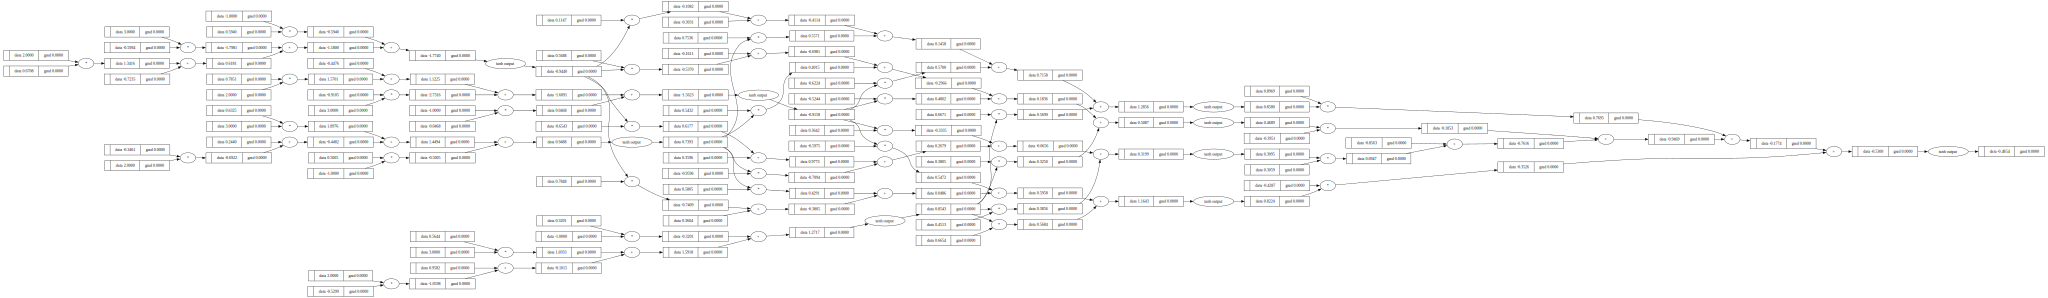

In [10]:
class Neuron:
    # nin number of input that comming into a neuron
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
        act = __builtin__.sum([wi*xi for wi,xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out


class Layer:
    def __init__(self, nin, nout):
        self.neurons =  [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        
x = [2.0, 3.0, -1]
n =  MLP(3, [4,4,1])
n(x)
draw_dot(n(x))

In [11]:
n =  MLP(3, [4,4,1])

In [12]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.5771969482382313),
 Value(data=0.10927994150075915),
 Value(data=0.2093931286009786),
 Value(data=-0.6142764162937032)]